This notebook corresponds to Week 4 of the IBM Data Science Capstone, in which we find a way of clustering various neighborhoods in Toronto.

In [1]:
import pandas as pd
import numpy as np
import requests
import json

First, we read the tabulated data from the wikipedia site (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', flavor='bs4')[0]
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


Drop any rows that have "Not Assigned" as a value for borough, and assign `neighborhood=borough` for rows with a value for "Not assigned" only for the neighborhood.

In [3]:
# ~(df[['Borough']] == 'Not assigned').any(axis=1)
df = df.loc[~(df[['Borough']] == 'Not assigned').any(axis=1), :].reset_index(drop=True)
no_neighborhood = df['Neighbourhood'] == 'Not assigned'
df.loc[no_neighborhood, 'Neighbourhood'] = df.loc[no_neighborhood, 'Borough']
df

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [4]:
df.groupby('Postal Code').count()

,Borough,Neighbourhood
Postal Code,,
M1B,1,1
M1C,1,1
M1E,1,1
M1G,1,1
M1H,1,1
...,...,...
M9N,1,1
M9P,1,1
M9R,1,1


Since the number of rows returned by `df.groupby('Postal Code').count()` matches the number of rows that we previously had, there aren't any duplicated postal codes in the table. Our preprocessing is done for now. Next, we geocode each postalcode using the geocoder package.

In [5]:
coordinates_df = pd.read_csv('https://cocl.us/Geospatial_data')
df = df.merge(coordinates_df, how='left', on='Postal Code')
df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


Next, we get venue information for each neighborhood using foursquare. We use the Explore function (which provides recommended venues/venues of interest as opposed to just the nearest venues), with a radius of 1.1 km per neighborhood and a search limit of 150 venues per neighborhood.

In [6]:
CLIENT_ID = 'KVW5PYILN4Y1TKDPIYGKJQHWP1LBWGIBSWWNG2HA1VBWNY2V'
CLIENT_SECRET = 'W3N00Z502D52M1MRGWT0QGYSIRD0K1BTJ2YHC5IQHTQ224KY'

In [7]:
#search query parameters
LIMIT = 150
RADIUS = 1100
version = '20201214'

def get_category(obj):
    if len(obj) == 0:
        return 'None'
    return obj[0]['shortName']

def get_neighborhood_venues(code, neighborhood, lat, long):
    print('Current Neighborhood(s): {}'.format(neighborhood))
    payload = {
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'll': '{},{}'.format(lat, long), 
        'radius': RADIUS, 
        'v': version, 
        'limit': LIMIT,
    }
    response = requests.get('https://api.foursquare.com/v2/venues/explore', params=payload).json()
    if 'groups' not in response['response']:
        print(neighborhood, response)
        return None
    df = pd.json_normalize(response['response']['groups'][0]['items'])
    df.columns = [header.replace('venue.', '') for header in df.columns]
    relevant_categories = ['postal_code', 'neighborhood', 'id', 'name', 'categories', 'location.lat', 'location.lng']
    df['postal_code'] = code
    df['neighborhood'] = neighborhood
    if 'categories' not in df:
        print(neighborhood, response)
        return None
    df['categories'] = df['categories'].apply(lambda j: get_category(j))
    df = df[relevant_categories]
    return df

venues_list = [get_neighborhood_venues(row._1, row.Neighbourhood, row.Latitude, row.Longitude) for row in df.itertuples()]
combined_df = pd.concat(venues_list, axis=0)
print(combined_df.shape)
combined_df

Current Neighborhood(s): Parkwoods
Parkwoods {'meta': {'code': 400, 'errorType': 'invalid_auth', 'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.', 'requestId': '5fe7edb68c47f042d7974d40'}, 'response': {}}
Current Neighborhood(s): Victoria Village
Victoria Village {'meta': {'code': 400, 'errorType': 'invalid_auth', 'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.', 'requestId': '5fe7edb6ba6fa474b8368901'}, 'response': {}}
Current Neighborhood(s): Regent Park, Harbourfront
Regent Park, Harbourfront {'meta': {'code': 400, 'errorType': 'invalid_auth', 'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.', 'requestId': '5fe7edb6732a472e70a0293c'}, 'response': {}}
Current Neighborhood(s): Lawrence Manor, Lawrence Heights
Lawrence Manor, Lawrence Heig

ValueError: All objects passed were None

Now that we have the data, let's see how many unique categories our venues encompass:

In [113]:
combined_df['categories'].unique().shape

(331,)

Next, let's drop any venues with a category of "None" and any venues within a category that has less than 5 total venues (therefore only keeping venues that have a decent amount of representation in the dataset.)

In [114]:
irrelevant_categories = ['None', 'Intersection', 'Moving Target', 'Coffee Shop']
combined_df = combined_df[~combined_df['categories'].isin(irrelevant_categories)]
count_df = combined_df.groupby('categories').count()
count_common = count_df[count_df['id'] > 5].index.values
count_common.shape


(146,)

In [115]:
common_df = combined_df.loc[combined_df['categories'].isin(count_common), :]
common_df.shape

(4482, 7)

Great, we've nearly halved the number of features and reduced the size of our dataset by about 7%! Now, let's turn the categories into one-hot columns.

In [116]:
clustering_categories = ['postal_code', 'categories', 'name', 'location.lat', 'location.lng']
common_df = common_df[clustering_categories]
common_df = pd.get_dummies(common_df, columns=['categories'], prefix='', prefix_sep='')
common_df.columns = [k.replace(' ','') for k in common_df.columns]
print(common_df.shape)
common_df

(4482, 150)


,postal_code,name,location.lat,location.lng,American,Apparel,ArtGallery,Arts&Crafts,Asian,Athletics&Sports,...,Toys&Games,Trail,TrainStation,Turkish,Vegetarian/Vegan,VideoGames,Vietnamese,WineBar,Wings,YogaStudio
0,M3A,Allwyn's Bakery,43.759840,-79.324719,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,Tim Hortons,43.760668,-79.326368,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,Donalda Golf & Country Club,43.752816,-79.342741,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M3A,Brookbanks Park,43.751976,-79.332140,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M3A,Bruno's valu-mart,43.746143,-79.324630,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,M8Z,Queensway Fish & Chips,43.621720,-79.524588,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,M8Z,Global Pet Foods,43.621304,-79.526146,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,M8Z,Buns Masterbakery,43.633880,-79.531686,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,M8Z,Soccer Season,43.624862,-79.509344,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we group the dataframe by postcode/neighborhood, and take each neighborhood's mean for each feature. This indicates how frequently venues of a category appear in the neighborhood -- a mean of "1" for a category for a neighborhood would indicate that every venue in that neighborhood belongs to a category.

In [128]:
nhood_df = common_df.groupby('postal_code').mean()
nhood_df.rename(columns={'location.lat': 'lat', 'location.lng': 'lng'}, inplace=True)
print(nhood_df.head(10))
nhood_df.shape
print(nhood_df.columns.values)

                   lat        lng  American  Apparel  ArtGallery  Arts&Crafts  \
postal_code                                                                     
M1B          43.801150 -79.198098       0.0      0.0         0.0          0.0   
M1C          43.783213 -79.164095       0.0      0.0         0.0          0.0   
M1E          43.769618 -79.186650       0.0      0.0         0.0          0.0   
M1G          43.766258 -79.216434       0.0      0.0         0.0          0.0   
M1H          43.775603 -79.240638       0.0      0.0         0.0          0.0   
M1J          43.743394 -79.240074       0.0      0.0         0.0          0.0   
M1K          43.730368 -79.262437       0.0      0.0         0.0          0.0   
M1L          43.710475 -79.285258       0.0      0.0         0.0          0.0   
M1M          43.716338 -79.238284       0.0      0.0         0.0          0.0   
M1N          43.694256 -79.266193       0.0      0.0         0.0          0.0   

                Asian  Athl

Next, we standardize the data. This allows us to factor coordinates into our clustering; otherwise, the magnitude of the coordinates would outweigh all other factors when determining clusters. I consider the coordinates a factor because, for instance, many Italian restaurants in close proximity would indicate an Italian neighborhood; this physical grouping would be lost if coordinates aren't considered. Also, we preserve the mean and the variance of the latitude and longitude columns so that we can scale the means we find during clustering to valid coordinates.

In [129]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

data_df = nhood_df.loc[:, ~(nhood_df.columns.isin(['postal_code', 'name']))]
data_df_columns = data_df.columns.to_list()
coordinate_scaler = MinMaxScaler()
feature_scaler = MinMaxScaler()
data_df = np.array(data_df)
data_df[:, :2] = coordinate_scaler.fit_transform(data_df[:, :2])
data_df[:, 2:] = feature_scaler.fit_transform(data_df[:, 2:])
# print(data_df.mean(axis=0))
data_df

array([[0.94664422, 0.92576585, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.86105833, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.7961958 , 0.95075894, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.41616173, 0.13542423, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.65693661, 0.07651282, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.49624942, 0.06303311, 0.        , ..., 0.        , 0.        ,
        0.        ]])

As a bonus step, I apply a factor to the scaled coordinate columns, so that I can control their influence on the determination of clusters.

In [130]:
LOCATION_WEIGHT_FACTOR = 7.5
data_df[:, :2] = data_df[:, :2] * LOCATION_WEIGHT_FACTOR
data_df

array([[7.09983163, 6.94324385, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [6.45793744, 7.5       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [5.97146849, 7.13069202, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.12121297, 1.01568175, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [4.92702458, 0.57384616, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.72187068, 0.47274835, 0.        , ..., 0.        , 0.        ,
        0.        ]])

We're ready for kmeans! Let's use a knee-finding plot to see what the optimal k is for us to choose.

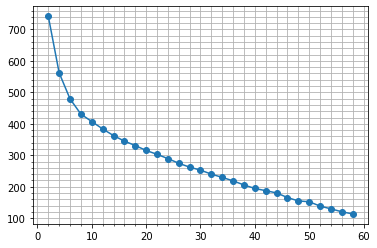

In [131]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

K = range(2, 60, 2)
inertias = []
for km in K:
    test_kmeans = KMeans(n_clusters=km)
    test_kmeans.fit(data_df)
    inertias.append(test_kmeans.inertia_)

plt.plot(K, inertias, '-o')
plt.grid(which='both')
plt.minorticks_on()


There doesn't seem to be a strict "elbow", so we can pick a value that seems reasonable enough to us - we don't want the inertia to be too high, but we also don't want to have too many clusters that we lose meaning of neighborhood groupings. Let's choose k=15.

In [132]:
CLUSTERS = 15
kmeans = KMeans(n_clusters=CLUSTERS, random_state=1)
kmeans.fit(data_df)

KMeans(n_clusters=15, random_state=1)

In [133]:
clustered_df = nhood_df.copy()
clustered_df.insert(0, 'cluster', kmeans.labels_)
clustered_df.head()

,cluster,lat,lng,American,Apparel,ArtGallery,Arts&Crafts,Asian,Athletics&Sports,BBQ,...,Toys&Games,Trail,TrainStation,Turkish,Vegetarian/Vegan,VideoGames,Vietnamese,WineBar,Wings,YogaStudio
postal_code,,,,,,,,,,,,,,,,,,,,,
M1B,4,43.801150,-79.198098,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.133333,0.0,0.0,0.0,0.066667,0.0,0.0,0.00000,0.00000
M1C,4,43.783213,-79.164095,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.00000
M1E,4,43.769618,-79.186650,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.047619,0.0,0.0,0.00000,0.00000
M1G,4,43.766258,-79.216434,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.00000
M1H,4,43.775603,-79.240638,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.03125,0.03125


In [134]:
centroid_array = kmeans.cluster_centers_
centroid_array[:, :2] = coordinate_scaler.inverse_transform(centroid_array[:, :2]/LOCATION_WEIGHT_FACTOR)
# centroid_array[:, 2:] = feature_scaler.inverse_transform(centroid_array[:, 2:])
centroid_df = pd.DataFrame(centroid_array, columns = data_df_columns)
centroid_df

,lat,lng,American,Apparel,ArtGallery,Arts&Crafts,Asian,Athletics&Sports,BBQ,Bagels,...,Toys&Games,Trail,TrainStation,Turkish,Vegetarian/Vegan,VideoGames,Vietnamese,WineBar,Wings,YogaStudio
0,43.751252,-79.534667,1.185185e-01,0.000000e+00,0.000000e+00,2.000000e-01,-1.387779e-17,6.666667e-02,0.000000e+00,-6.938894e-18,...,-6.938894e-18,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,1.439153e-01,-6.938894e-18,0.000000e+00,0.000000e+00
1,43.665230,-79.338157,2.594378e-01,0.000000e+00,0.000000e+00,9.171687e-02,1.155702e-01,0.000000e+00,1.100613e-01,0.000000e+00,...,0.000000e+00,3.645833e-02,0.000000e+00,0.000000,0.095783,0.000000e+00,8.895582e-02,0.000000e+00,0.000000e+00,1.596386e-01
2,43.653388,-79.413257,1.190492e-01,0.000000e+00,3.884946e-01,1.598288e-01,1.068966e-01,6.933830e-02,0.000000e+00,-6.938894e-18,...,-6.938894e-18,1.891892e-02,0.000000e+00,0.000000,0.672823,0.000000e+00,6.780418e-02,4.205712e-01,0.000000e+00,3.171523e-01
3,43.777368,-79.391179,4.000000e-02,1.000000e-01,-2.775558e-17,1.011236e-02,3.875000e-02,1.387779e-17,0.000000e+00,9.285714e-02,...,1.000000e-01,1.010230e-01,-3.469447e-18,0.000000,0.000000,3.750000e-02,8.988764e-03,-2.081668e-17,2.247191e-02,2.846442e-02
4,43.785743,-79.223181,1.387779e-17,6.938894e-18,0.000000e+00,0.000000e+00,0.000000e+00,4.017857e-02,0.000000e+00,6.938894e-18,...,0.000000e+00,1.333333e-01,3.469447e-18,0.000000,0.098701,2.448980e-01,1.680672e-02,-6.938894e-18,8.928571e-02,1.130952e-01
5,43.636346,-79.547961,0.000000e+00,1.333333e-01,0.000000e+00,0.000000e+00,3.191964e-01,0.000000e+00,3.571429e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.928571e-02,2.261905e-01
6,43.702978,-79.327849,9.363023e-02,2.727273e-02,4.797980e-02,9.036145e-03,7.619497e-02,1.621871e-01,5.181694e-02,5.693464e-02,...,8.032129e-02,1.264726e-01,-3.469447e-18,0.037698,0.078594,-6.938894e-18,1.387779e-17,-1.387779e-17,3.831418e-02,1.129140e-01
7,43.700638,-79.411017,1.414153e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.343750e-02,0.000000e+00,6.788402e-01,...,0.000000e+00,1.381770e-01,3.469447e-18,0.000000,0.175056,6.938894e-18,1.825980e-02,8.529412e-02,8.547009e-02,2.720240e-01
8,43.747818,-79.286812,1.387779e-17,0.000000e+00,-1.387779e-17,0.000000e+00,3.193380e-01,1.387779e-17,0.000000e+00,5.803571e-02,...,0.000000e+00,6.938894e-18,6.980519e-02,0.000000,0.000000,6.250000e-02,6.722222e-02,-1.387779e-17,5.952381e-02,2.775558e-17
9,43.658501,-79.382547,1.918163e-01,9.703945e-02,3.880080e-01,4.101731e-02,2.279412e-02,1.480263e-02,4.904239e-02,6.938894e-18,...,0.000000e+00,6.938894e-18,8.823529e-03,0.000000,0.230716,0.000000e+00,1.234756e-02,-1.387779e-17,0.000000e+00,3.531086e-01


For a quick sanity check, let's use the example of Greektown, a neighborhood in Toronto. Greektown has a high concentration of Greek restaurants and businesses, and is located in the West Danforth neighborhood (with a postcode of M1K). 

In [135]:
print(clustered_df[['cluster', 'Greek']].sort_values(by='Greek', ascending=False))
print(centroid_df.loc[:, 'Greek'].sort_values().tail(10))

             cluster     Greek
postal_code                   
M4K                6  0.142857
M4J                6  0.084337
M1E                4  0.047619
M1T                8  0.033333
M5M                7  0.025641
...              ...       ...
M3N                0  0.000000
M3M               12  0.000000
M3L                0  0.000000
M3K               12  0.000000
M9W               12  0.000000

[102 rows x 2 columns]
9     0.010671
12    0.011218
7     0.029915
2     0.032371
13    0.035133
11    0.040389
10    0.040703
4     0.047619
8     0.050000
6     0.139558
Name: Greek, dtype: float64


That checks out! The postal code with the highest frequency of Greek restaurants was placed in the cluster with the highest mean value for the Greek category. As a result, we can use the output of the k-means clustering to make a table listing the 6 most defining categories for each cluster - in other words, the categories with the highest values.

In [136]:
N = 6

centroid_categories = centroid_df.drop(['lat', 'lng'], axis=1)
# get the top N columns for each centroid
sorted_categories = np.argsort(-centroid_categories, axis=1)
categories = centroid_categories.columns[sorted_categories][:, :N]
# join the (k, N) matrix of top N columns for each mean k with the (k, 2) matrix corresponding to
# the latitude and longitude of each mean
centroid_topN_df = pd.concat([centroid_df[['lat', 'lng']], 
                            pd.DataFrame(categories, columns=list(range(N + 1)[1:]))], axis=1)
centroid_topN_df


<ipython-input-136-45f6711017e4>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  categories = centroid_categories.columns[sorted_categories][:, :N]


,lat,lng,1,2,3,4,5,6
0,43.751252,-79.534667,Pizza,Mall,GroceryStore,Caribbean,Bank,BeerStore
1,43.665230,-79.338157,Bistro,ComicShop,Snacks,Diner,Steakhouse,Bar
2,43.653388,-79.413257,Café,Vegetarian/Vegan,Bar,BeerBar,Cocktail,ComfortFood
3,43.777368,-79.391179,Bank,Restaurant,Pizza,Japanese,Mall,Sandwiches
4,43.785743,-79.223181,Caribbean,Chinese,Bakery,Pizza,FastFood,Indian
5,43.636346,-79.547961,Mexican,Restaurant,Burritos,Bank,Asian,EasternEuropean
6,43.702978,-79.327849,Café,Gym,BeerStore,Thai,SportingGoods,Restaurant
7,43.700638,-79.411017,Sushi,Bagels,Bank,Gastropub,Spa,Deli/Bodega
8,43.747818,-79.286812,Pizza,Asian,Sandwiches,Restaurant,GroceryStore,Caribbean
9,43.658501,-79.382547,HistoricSite,Theater,Creperie,ComicShop,Plaza,Gastropub


Finally, let's add a scale factor to each mean based on the number of points it contains. This will help us display the means better on the map.

In [137]:
clustered_grouped = clustered_df.groupby('cluster').count()
total = clustered_grouped['lat'].sum()
centroid_topN_df['scale'] = clustered_grouped['lat']/total
centroid_topN_df

,lat,lng,1,2,3,4,5,6,scale
0,43.751252,-79.534667,Pizza,Mall,GroceryStore,Caribbean,Bank,BeerStore,0.049020
1,43.665230,-79.338157,Bistro,ComicShop,Snacks,Diner,Steakhouse,Bar,0.039216
2,43.653388,-79.413257,Café,Vegetarian/Vegan,Bar,BeerBar,Cocktail,ComfortFood,0.049020
3,43.777368,-79.391179,Bank,Restaurant,Pizza,Japanese,Mall,Sandwiches,0.098039
4,43.785743,-79.223181,Caribbean,Chinese,Bakery,Pizza,FastFood,Indian,0.068627
5,43.636346,-79.547961,Mexican,Restaurant,Burritos,Bank,Asian,EasternEuropean,0.039216
6,43.702978,-79.327849,Café,Gym,BeerStore,Thai,SportingGoods,Restaurant,0.117647
7,43.700638,-79.411017,Sushi,Bagels,Bank,Gastropub,Spa,Deli/Bodega,0.058824
8,43.747818,-79.286812,Pizza,Asian,Sandwiches,Restaurant,GroceryStore,Caribbean,0.078431
9,43.658501,-79.382547,HistoricSite,Theater,Creperie,ComicShop,Plaza,Gastropub,0.078431


Now, we're ready to visualize the clusters! Here, I plot the different clusters as larger circles, whose size depends on the number of postal codes it has. The associated postal codes are also plotted in the same color.

In [138]:
import folium
import random

# get a random selection of colors for each cluster
random.seed(3)
levels = range(32,256,16)
colors = ['#%02x%02x%02x' % tuple(random.sample(levels, k=3)) for _ in range(CLUSTERS)]

toronto_map = folium.Map(location=[43.6532, -79.3832], zoom_start=11)
neighborhoods = folium.map.FeatureGroup()
clusters = folium.map.FeatureGroup()

#plot each cluster, labeling it with the top 6 categories found for each cluster + their score.
for i, row in enumerate(centroid_topN_df.itertuples()):
    label = 'Cluster {}:\n'.format(row.Index)
    for j in range(3, N + 3):
        category = getattr(row, '_{}'.format(j))
        label += '{0}: {1:1.2f}\n'.format(category, centroid_df.loc[row.Index, category])
    clusters.add_child(folium.CircleMarker(
    location=[row.lat, row.lng],
    radius= 500*(row.scale),
    popup=label,
    color=colors[i],
    fill=True,
    fill_color=colors[i]
    ))

#plot each neighborhood, ensuring that its color corresponds to the cluster it was assigned to.
for row in clustered_df.itertuples():
    neighborhoods.add_child(folium.CircleMarker(
    location=[row.lat, row.lng],
    radius=5,
    popup=row.Index,
    color=colors[row.cluster],
    fill=True,
    fill_color=colors[row.cluster]
    ))

clusters.add_to(toronto_map)
neighborhoods.add_to(toronto_map)
toronto_map


Examining our map of clusters/centroids, we can see some successful results, especially for areas where ethnic enclaves are located.  For instance, cluster 11 contains postal codes in the Scarborough region, which has a relatively high Caribbean immigrant population; this is reflected in the clustering, since we can observe that cluster 11 has a high score for the Caribbean category. We also see some unexpected information: The downtown cluster (cluster 0, teal) has a high score for not only historic sites (somewhat expected) but also creperies; the presence of creperies is unique to the downtown area.

For further analysis, I would like to see the effect of other clustering methods on this dataset. Hierarchical clustering in particular should do very well, since the features that were examined in this analysis were mostly categorical.